text is one of the most widespread forms of sequence data, it can be understood as either a sequence of characters or a sequence of words, but it's most common to work at the level of words

deep-learning models don't take as input raw text: they only work with numeric tensors. Vectorizing text is the process of transforming text into numeric tensors, this can be done in multiple ways:
- segment text into words, and transform each word into a vector
- segment text into characters, and transform each character into a vector
- extract n-grams of words or characters, and transform each n-gram into a vector (n-grams are overlapping groups of multiple consectuive words or characters)

- collectively, the different units into which you can break down text (words, characters, or n-grams) are called 'tokens', and breaking text into such tokens is called tokenization
- all text-vectorization process consist of applying some tokenization scheme and then associating numeric vectors with the generated tokens
- these vectors, packed into sequence tensors, are fed into deep neural networks

two major ones: 
- one-hot encoding of tokens
- token embedding (typically used exclusively for words, and called word embedding)

![From Text to Tokens to Vector](./text_to_tokens_to_vectors.png)

##### Understanding N-Grams and Bag-of-words

word n-grams are group of N (or fewer) consecutive words that you can extract from a sentence, the same concept may also be applied to characters instead of words

![n-grams and bag-of-words](./n_grams_example.png)

- because bag-of-words isn't and order-preserving tokenization method (the tokens generated are understood as a set, not a sequence, and the general structure of teh sentences is lost), it tends to be used in shallow language-processing models rather than in deep learning models
- extracting n-grams is a form of feature engineering, and deep learning does away with this kind of rigid, brittle approcah, replacing it with hierarchical feature learning
- n-grams are a powerful, unavoidable feature-engineering tool when using lightweight, shallow text-processing models such as logistic regression and random forests

### One-hot Encoding of Words and Characters

consist of associating a unique integer index with every word and then turning this integer index i into a binary vector of size N (the size of the vocabulary); tthe vector is all zeros except for the ith entry, which is 1

In [1]:
# word-level one-hot encoding (toy example)

import numpy as np

# initial data: one entry per sample (in this example, a sample is a sentence, but it coule be an entire document)
samples = ['OpenAI launched the multimodal model GPT-4.',
           'GPT-4 exhibits human-level performance on various profassional and academic benchmarks.']

# build an index of all tokens in the data
token_index = {}
for sample in samples: 
    # tokenize the samples via the split method, in real life, you'd also strip punctuation and special characters from the samples
    for word in sample.split():
        if word not in token_index:
            # assigns a unique index to each unique word, note that don't attribute index 0 to anything
            token_index[word] = len(token_index) + 1
            
# vectorize the samples, only consider the first max_length words in each sample
max_length = 30

# store the results
results = np.zeros(shape=(len(samples), 
                   max_length, 
                   max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1
        
print(results)

[[[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [2]:
# character-level one-hot encoding (toy example)
import string

samples = ['OpenAI launched the multimodal model GPT-4.',
           'GPT-4 exhibits human-level performance on various profassional and academic benchmarks.']

# all printable ASCII characters
characters = string.printable
token_index = dict(zip(range(1, len(characters) + 1), characters))

max_length = 100
results = np.zeros((len(samples), max_length, max(token_index.keys()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample):
        index = token_index.get(character)
        results[i, j, index] = 1
        
print(results)

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


keras has built-in utilities for doing one-hot encoding of text at the word level or character level

In [3]:
# using keras for word-level one-hot encoding

from keras.preprocessing.text import Tokenizer

samples = ['OpenAI launched the multimodal model GPT-4.',
           'GPT-4 exhibits human-level performance on various profassional and academic benchmarks.']

# create a tokenizer, configured to only take into account the 2000 most common words
tokenizer = Tokenizer(num_words=2000)

# build the word index
tokenizer.fit_on_texts(samples)

# turns strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(samples)

# get the one-hot binary representations, vectorization modes other than one-hot encoding are supported by this tokenizer
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# how can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17 unique tokens.


one-hot encoding hasing trick:
- when the number of unique tokens in your vacabulary is too large to handle explicitly, instead of explicitly assigning an index to each word and keeping a reference of these indices in a dictionary, you can hasd words into vectors of fixed size
- typically done with a very lightweight hashing function
- the main advanatage of this method is maintaining an explicit word index, which saves memory and allows online encoding of the data (you can generate token vectors right away, before seen all of the available data)
- drawback -- susceptible to hash collisions: 
    - two different words may end up with the same hash, and subsequently any machine learning model looking at these hases won't be able to tell subsequently any machine-learning model looking at these hashes won't be able to tell the difference between these words
    - the likelihood of hash collisions decreses when the dimensionality of the hashing space is much larger than the total number of unique tokens being hashed

In [4]:
# word-level one-hot encoding with hashing trick (toy example)
samples = ['OpenAI launched the multimodal model GPT-4.',
           'GPT-4 exhibits human-level performance on various profassional and academic benchmarks.']

# store the words as vectors of size 2000, 
# if the words is close to , or more than 2000, there will be collisions,
# which will decrease the accuracy of this encoding method
dimensionality = 2000
max_length = 16

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # hash the words into a random integer index between 0 and 2000
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1

### Using Word Embeddings

whereas the vectors obtained through one-hot encoding are binary, sparse (mostly mdae of zero), and very high-dimensional (same dimensionality as the number of words in the vocabulary), word embeddings  are low-dimensional floating-point vectors (that is, dense vectors, as oppoed to sparse vectors)

![oh-emb_representation](./oh-emb_rept.png)

word embeddings pack more information into far fewer dimensions

two ways to obtain word embeddings: 
- learn word embeddings jointly with the main task (such as document classification or sentiment prediction)
    - in this setup, start with random word vectors and then learn word vectors in the same way learned the weights of a neural network
- load into the model word embeddings that were precomputed using a different machine-learning task than the one trying to solve
    - pretrained word embeddings

##### Learning Word Embedding with the Embedding Layer

- the simplest way to associate a dense vector with a word is to choose the vector at random
 - the problem is the resulting embedding space has no structure: for instance, the words accurate and exact may end up with completely different embeddings, even though they're interchangable in most sentences, it's difficult for a depp neural network to make sense of such a noisy, unstrctureed embedding space

- to be more abstract, the geometric relationships between word vectors should reflect the semantic relationships betwee nthese words. 
- in a resonable embedding space, you would expect synonyms to be embedded into similar word vectors; and in general, you would expect the geometric distance between any two word vectors to relate to the semantic distance between the associated words (words meaning different things are embedded at points far away from each other, whereas related words are closer)
- in addition to distance, you may want specific directions in teh embedding space to be meaningful

![word_embedding_space](word_emb_space.png)

"Is there some ideal word-embedding space that would perfectly map human language and could be used for any natural-language-processing task? Possibly, but we
have yet to compute anything of the sort. Also, there is no such a thing as human language—there are many different languages, and they aren’t isomorphic, because a language is the reflection of a specific culture and a specific context. But more
pragmatically, what makes a good word-embedding space depends heavily on your task:
the perfect word-embedding space for an English-language movie-review sentimentanalysis model may look different from the perfect embedding space for an Englishlanguage legal-document-classification model, because the importance of certain
semantic relationships varies from task to task."

it's thus reasonable to learn a new embedding space with every new task, fortunately, backpropagation makes this easy, and Keras makes it even easier -- learning the weights of a layer: the 'Embedding' layer

In [5]:
# instantiating an embedding layer
from keras.layers import Embedding

# the embedding layer takes at least two arguments: the number of possible tokens (here, 1000:1 + maximum word index)  and the dimensionality of the embedding (here, 64) 
embedding_layer = Embedding(1000, 64)

- the embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors 
- it takes integers as input, it looks up these integers in an internal dictionary, and it returns the associated vectors

- the embedding layer takes as input a 2D tensor of integers -- (samples, sequence_length), where each entry is a sequence of integers
- all sequences in a batch must have the same length (because they need to be pack into a single tensor)
    - sequences taht are shorter should be padded with zeros, and sequences that are longer should be truncated

the layer returns a 3D floating-point tensor of shape (samples, sequence_length, embedding_dimensioinality), such a 3D tensor can then be processed by an RNN layer or a 1D convolution layer

- when instantiating an embedding layer, its weights (its internal dicionary of token vectors) are initially random
- during training, these word vectors are gradually adjusted via backpropagation, structuring the space into something the downstram model can exploit
- once fully trained, the embedding space will show a lot of structure -- a kind of structure specialized for the specific problem

In [6]:
# loading the IMDB data for use with an embedding layer
from keras.datasets import imdb
from keras import preprocessing
from keras.utils import pad_sequences

max_features = 10000
maxlen = 20

# load the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# turn the lists of integers into a 2D integer tensor of shape (samples, maxlen)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [7]:
# using an embedding layer and classifier on the IMDB data
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# specifies the maximum input length to the embedding layer so can later flatten the embedded inputs
# after the embedding layer, the activations have shape (smaples, maxlen, 8)
model.add(Embedding(10000, 8, input_length=maxlen))

# flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())

# adds the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 3s 2ms/step - loss: 0.6685 - acc: 0.6315 - val_loss: 0.6205 - val_acc: 0.6996
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5447 - acc: 0.7516 - val_loss: 0.5289 - val_acc: 0.7272
Epoch 3/10
625/625 [==============================] 

- merely flattening the embedded sequences and training a single Dense layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and sentence structure
- it's much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole

##### Using Pretrained Word Embeddings

instead of learning word embeddings jointly with teh problem you want to solve, you can load embedding vectors from a precomputed embedding space that known is highly structured and exhibit useful properties -- that captures generic aspects of language structure

- the Word2vec algorithm; https://code.google.com/archive/p/word2vec
- global vectors for word representation (GloVe): https://nlp.stanford.edu/projects/glove

### Putting it All Together: from Raw Text to Word Embeddings

##### Downloading the IMDB Data as Raw Text

- download the raw IMDB dataset and uncompress it: http://mng.bz/0tIo
- collect the individual training reviews into a list of srings, one string per review
- collect the review labels (positive/negative) into a labels list

In [8]:
# processing the labels of the raw IMDB data
import os

imdb_dir = 'C:/Users/jim_c/Desktop/Task/Literature/Deep_Learning_with_Python/Deep_Learning_in_Practice/deep_learning_for_text_and_sequences/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

# _*_ coding:utf-8 _*_
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), 'r', encoding='UTF-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

- vectorize the text and prepare a training and validation split, because pretrained word embeddings are meant to be particularyly useful on problmes where little training data is available
- twist: restricting the training data to the first 200 examples

##### Tokenizing the Data

In [9]:
# tokenizing the text of the raw imdb data
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # cuts off reviews after 1000 words
training_samples = 200 # train on 200 samples
validation_samples = 10000 # validates on 10000 samples
max_words = 10000 # considers only the top 10000 words in the data set

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# splits the data into a training set and a validation set, but first shuffles the data, 
# because the data strating in samples are ordered (all negative first, then all positive)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


##### Downloading the GloVe Word Embeddings

- precomputed embeddings from 2014 English Wikipedia: https://nlp.stanford.edu/projects/glove

##### Preprocessing the Embeddings

parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation (as number vectors)

In [10]:
# parsing the GloVe word-embeddings file
glove_dir = 'C:/Users/jim_c/Desktop/Task/Literature/Deep_Learning_with_Python/Deep_Learning_in_Practice/deep_learning_for_text_and_sequences/glove.6B'

# _*_ coding:utf-8 _*_
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'r', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


- build an embedding matirx that load into an embedding layer, it must be a matrix shape (max_words, embedding_dim), where each entry i contains the embedding_dim - dimensional vector for the word of index i in teh reference word index (built during tokenization)
- note: index 0 isn't supposed to stand for any word or token -- it's a placeholder

In [11]:
# preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matirx = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matirx[i] = embedding_vector # words not found in the embedding index will be all zero

##### Defining a Model

In [12]:
# model definition
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                320032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


##### Loading the GloVe Embeddings in the Model

the embedding layer has a single weight matrix: a 2D float matirx where each entry i is the word vector meant to be associated with index i 

In [13]:
# loading pretrained word embeddings into the embedding layer
model.layers[0].set_weights([embedding_matirx])
model.layers[0].trainable = False

- freeze the embedding layer (set its trainable attribute to False)
- when parts of a model are pretrained (like your embedding layer) and parts of are randomly initialized (like your classifier), the pretrained parts shouldn't be updated during training, to avoid forgetting what they already know
- the large gradient updates triggered by the randomly initialized layers would be disruptive to the already-learned features

##### Train and Evaluating the Model

In [14]:
# training and evaluation
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 109ms/step - loss: 1.6567 - acc: 0.4900 - val_loss: 0.7324 - val_acc: 0.5037
Epoch 2/10
7/7 [==============================] - 1s 109ms/step - loss: 0.5213 - acc: 0.6900 - val_loss: 0.6999 - val_acc: 0.5472
Epoch 3/10
7/7 [==============================] - 1s 87ms/step - loss: 0.3888 - acc: 0.8350 - val_loss: 1.0079 - val_acc: 0.5009
Epoch 4/10
7/7 [==============================] - 1s 90ms/step - loss: 0.4441 - acc: 0.7250 - val_loss: 0.7823 - val_acc: 0.5292
Epoch 5/10
7/7 [==============================] - 0s 75ms/step - loss: 0.3057 - acc: 0.8750 - val_loss: 0.6871 - val_acc: 0.5756
Epoch 6/10
7/7 [==============================] - 0s 72ms/step - loss: 0.1439 - acc: 1.0000 - val_loss: 0.7153 - val_acc: 0.5710
Epoch 7/10
7/7 [==============================] - 0s 75ms/step - loss: 0.1896 - acc: 0.9350 - val_loss: 1.1606 - val_acc: 0.5050
Epoch 8/10
7/7 [==============================] - 0s 75ms/step - loss: 0.0740 - acc: 0.9950 - v

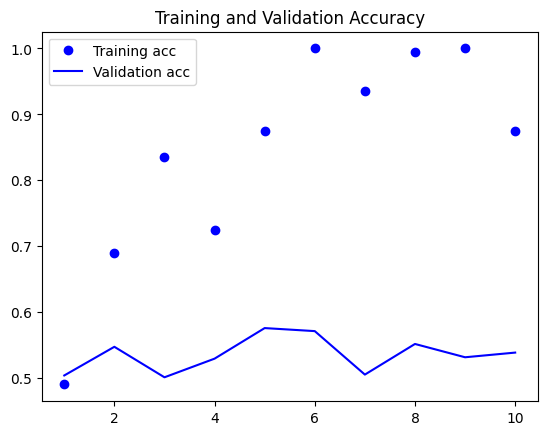

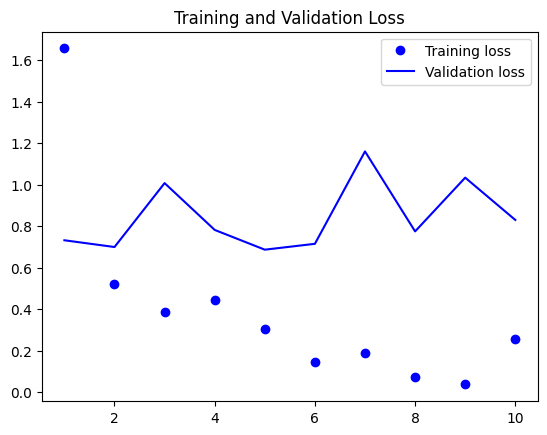

In [15]:
# plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

- the model quickly strats overfitting, which is unsurprising given the small number of training samples, same as the validation accuracy
- note that the mileage may vary, because of so few training samples, performance is heavily dependent on exactly which samples you choose

##### Train the Same Model without Pretrained Word Embeddings

without freezing the embedding layer. in that case, it will learn a task-specific embedding of the input tokens, which is generally more powerful tahn pretrained word embeddings when lots of data is available, but in this case, too few samples

In [16]:
# training the same model without pretrained word embeddings
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                320032    
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 103ms/step - loss: 0.7002 - acc: 0.5050 - val_loss: 0.6918 - val_acc: 0.5171
Epoch 2/10
7/7 [==============================

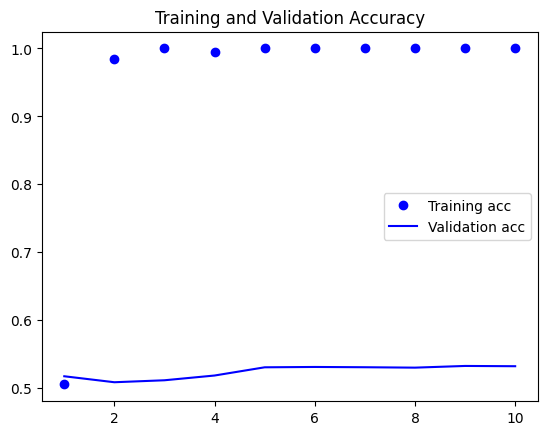

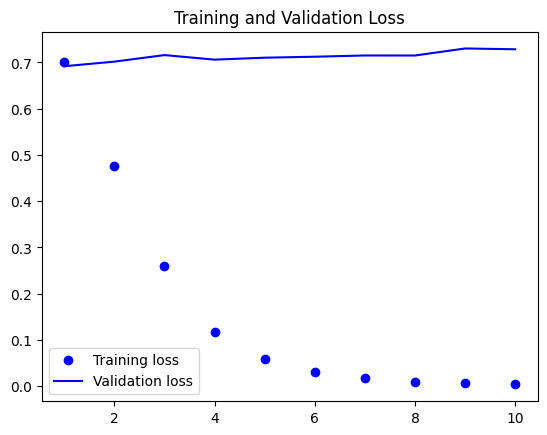

In [17]:
# plotting the results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

in this case, pretrained word embeddings outperform jointly learned embeddings, but if increase the number of training samples, this will quickly stop being the case

##### Evaluate the Model on the Test Data

In [18]:
# tokenizing the data of the test set
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

# _*_ coding:utf-8 _*_
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), 'r', encoding='UTF-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.array(labels)

In [20]:
# evaluating the model on the test set
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.8335 - acc: 0.5443


[0.833524763584137, 0.5442799925804138]

### Wrapping Up

- turn raw text into something a neural network can process
- use the embedding layer in keras model to learn task-specific token embeddings
- use pretrained word embeddings to get an extra boost on small natural language-processing problems